In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3+115.g1aecabf anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

	Single-cell RNAseq data was collected on whole early mouse embryos. Each experiment consists of 4-10 replicates of developmental stages 6.5, 7.0, 7.5, 8.0, 8.5 for wild-type sequenced with 10X Genomics single-cell RNA sequencing system.

In [4]:
# Set up data loading

#Data files
sample_strings = ['E6.5_1', 'E7.0_1', 'E7.5_1']
file_base = '../data/mammalian-embryogenesis/GSE122187_WT_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
#cc_genes_file = '../Macosko_cell_cycle_genes.txt'

In [5]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
data_file = file_base+sample+data_file_end
barcode_file = file_base+sample+barcode_file_end
gene_file = file_base+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['stage'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['exp_number'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
print(adata)

... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E6.5_1_matrix.h5ad
AnnData object with n_obs × n_vars = 1843 × 27998 
    obs: 'sample', 'stage', 'exp_number'
    var: 'gene_id'


In [6]:
print(adata.obs['sample'])

barcode
AAACCTGAGGTGTGGT-1    E6.5_1
AAACCTGGTAAGGATT-1    E6.5_1
AAACCTGGTACAGACG-1    E6.5_1
AAACCTGGTGTTCGAT-1    E6.5_1
AAACCTGTCAACACCA-1    E6.5_1
AAACGGGCATGTCCTC-1    E6.5_1
AAACGGGGTACATCCA-1    E6.5_1
AAACGGGTCCCTCTTT-1    E6.5_1
AAAGATGAGTCGTTTG-1    E6.5_1
AAAGATGCAGCTCGCA-1    E6.5_1
AAAGATGTCATGCTCC-1    E6.5_1
AAAGCAAAGTGAAGTT-1    E6.5_1
AAAGCAATCTCGTATT-1    E6.5_1
AAAGCAATCTTAGCCC-1    E6.5_1
AAAGTAGGTACACCGC-1    E6.5_1
AAAGTAGGTATGGTTC-1    E6.5_1
AAAGTAGGTGTGAAAT-1    E6.5_1
AAATGCCCAAATTGCC-1    E6.5_1
AAATGCCCAGATGAGC-1    E6.5_1
AAATGCCGTAATCACC-1    E6.5_1
AACACGTAGCTAACAA-1    E6.5_1
AACACGTCAAAGGAAG-1    E6.5_1
AACACGTCACAGGCCT-1    E6.5_1
AACACGTCATCGGGTC-1    E6.5_1
AACACGTGTTGGGACA-1    E6.5_1
AACCATGAGCCTATGT-1    E6.5_1
AACCATGAGCTGTTCA-1    E6.5_1
AACCATGCACAACGTT-1    E6.5_1
AACCATGGTTGAACTC-1    E6.5_1
AACCGCGAGGTCATCT-1    E6.5_1
                       ...  
TTGGCAAGTGCCTGTG-1    E6.5_1
TTGGCAATCAGGCGAA-1    E6.5_1
TTGTAGGAGTGGGTTG-1    E6.5_1
TTGTAG

In [7]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    data_file = file_base+sample+data_file_end 
    barcode_file = file_base+sample+barcode_file_end
    gene_file = file_base+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['stage'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['exp_number'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample')
    #adata.obs.drop(columns=['sample'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

    
print(adata)


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.0_1_matrix.h5ad


Making variable names unique for controlled concatenation.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.5_1_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 29917 × 27998 
    obs: 'exp_number', 'sample', 'stage'
    var: 'gene_id'


Once the data is read in and annotated, we test whether we have the expected number of cells for each region, mouse (donor), and sample.

In [8]:
# Annotate the data sets
print(adata.obs)
print(adata.obs['stage'].value_counts())
print('')
print(adata.obs['exp_number'].value_counts())
print('')
#print(adata.obs['sample'].value_counts())

                 exp_number sample stage
AAACCTGAGGTGTGGT          1      0  E6.5
AAACCTGGTAAGGATT          1      0  E6.5
AAACCTGGTACAGACG          1      0  E6.5
AAACCTGGTGTTCGAT          1      0  E6.5
AAACCTGTCAACACCA          1      0  E6.5
AAACGGGCATGTCCTC          1      0  E6.5
AAACGGGGTACATCCA          1      0  E6.5
AAACGGGTCCCTCTTT          1      0  E6.5
AAAGATGAGTCGTTTG          1      0  E6.5
AAAGATGCAGCTCGCA          1      0  E6.5
AAAGATGTCATGCTCC          1      0  E6.5
AAAGCAAAGTGAAGTT          1      0  E6.5
AAAGCAATCTCGTATT          1      0  E6.5
AAAGCAATCTTAGCCC          1      0  E6.5
AAAGTAGGTACACCGC          1      0  E6.5
AAAGTAGGTATGGTTC          1      0  E6.5
AAAGTAGGTGTGAAAT          1      0  E6.5
AAATGCCCAAATTGCC          1      0  E6.5
AAATGCCCAGATGAGC          1      0  E6.5
AAATGCCGTAATCACC          1      0  E6.5
AACACGTAGCTAACAA          1      0  E6.5
AACACGTCAAAGGAAG          1      0  E6.5
AACACGTCACAGGCCT          1      0  E6.5
AACACGTCATCGGGTC

In [9]:
# Checking the total size of the data set
adata.shape

(29917, 27998)

In [10]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

... storing 'exp_number' as categorical
... storing 'stage' as categorical


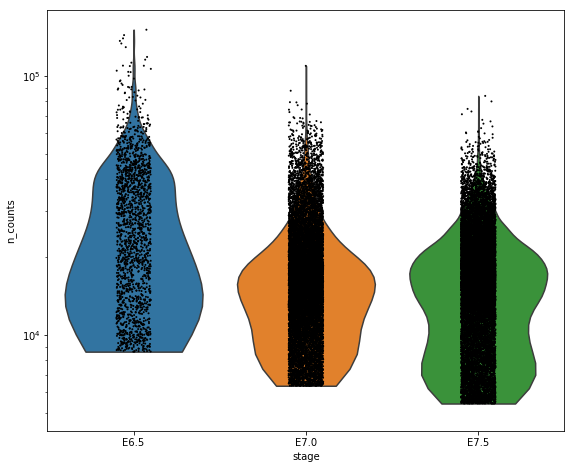

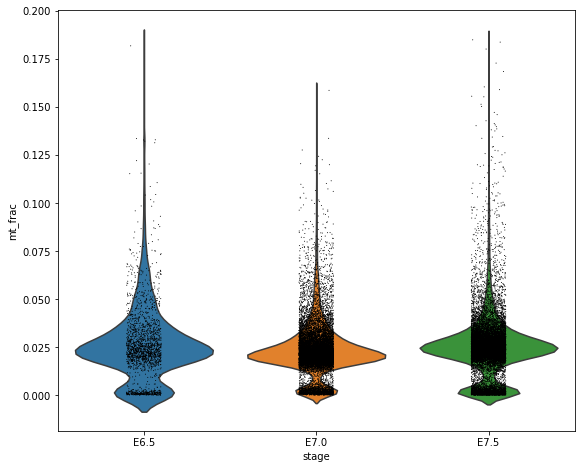

In [11]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='stage', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='stage')

Sample size for stage E6.5 is much smaller than the others and there appears to be two 'bulges'.

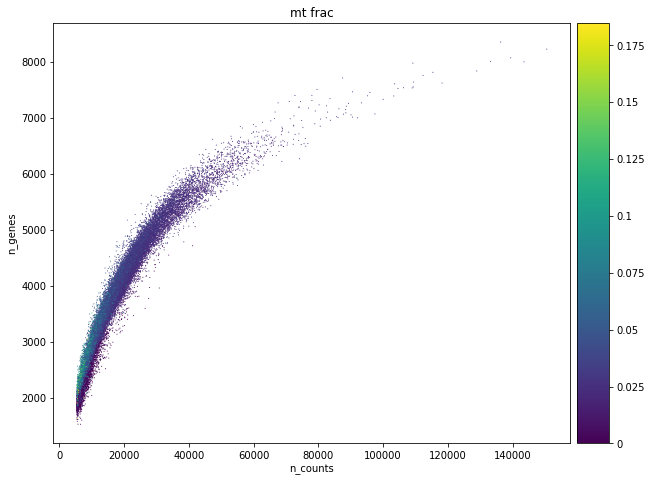

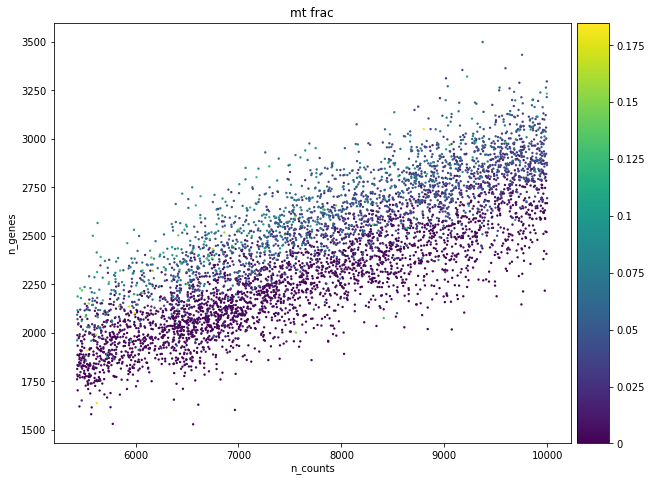

In [12]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

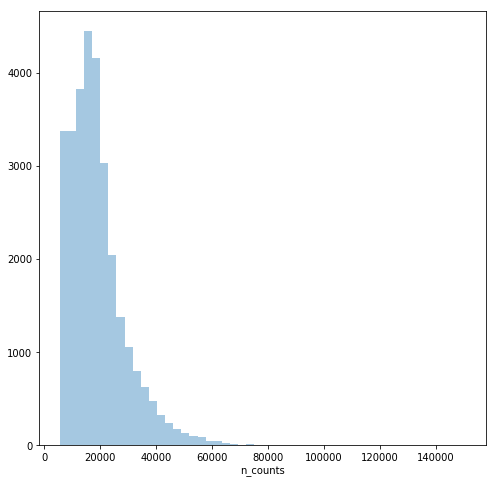

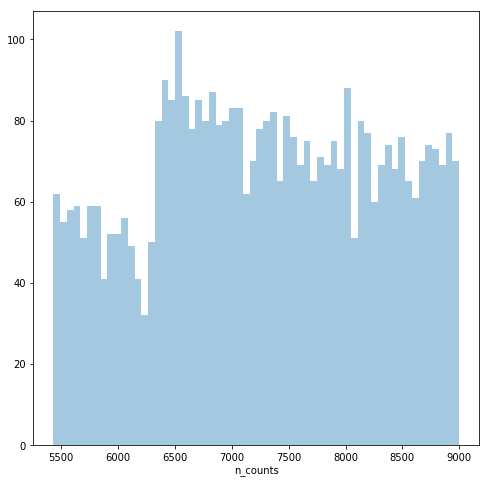

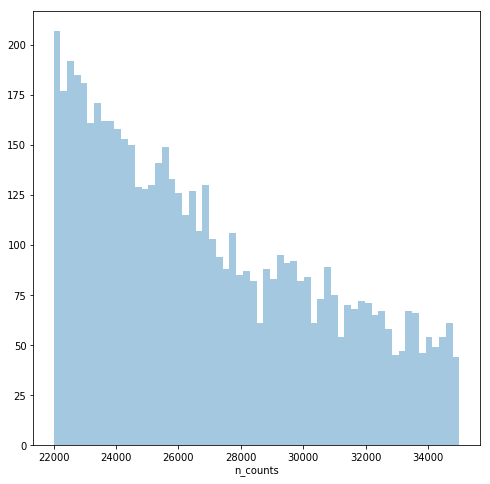

In [13]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<9000], kde=False, bins=60)
plt.show()

try_filter = adata.obs['n_counts'][(adata.obs['n_counts']>22000)  & (adata.obs['n_counts']<35000)]
p5 = sb.distplot(try_filter, kde=False, bins=60)
plt.show()

Histograms of the number of counts per cell show that there are two small peaks of groups of cells with fewer than 7000 counts. Given the overall distribution, unlikely to be informative.

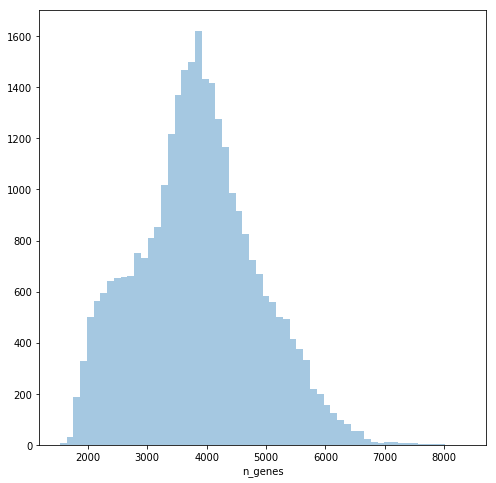

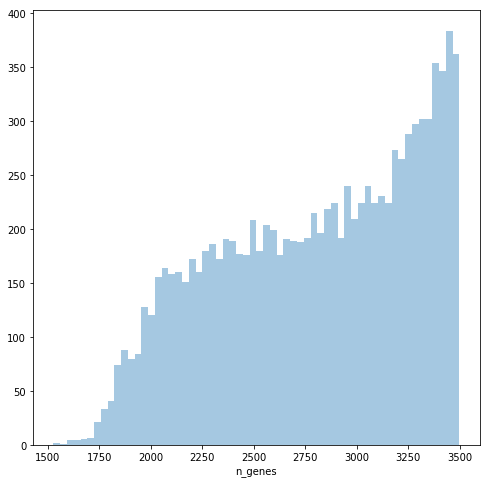

In [14]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<3500], kde=False, bins=60)
plt.show()


In [15]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 10000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))



Total number of cells: 29917
filtered out 5331 cells that haveless than 10000 counts
Number of cells after min count filter: 24586
filtered out 1326 cells that havemore than 40000 counts
Number of cells after max count filter: 23260
Number of cells after MT filter: 23260


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 23260


In [16]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 10845 genes that are detectedin less than 20 cells
Number of genes after cell filter: 17153


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

#2.2 Normalization

In [17]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:06): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDi

    finished (0:00:11)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:07)


In [19]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [20]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [21]:
#Delete adata_pp
del adata_pp

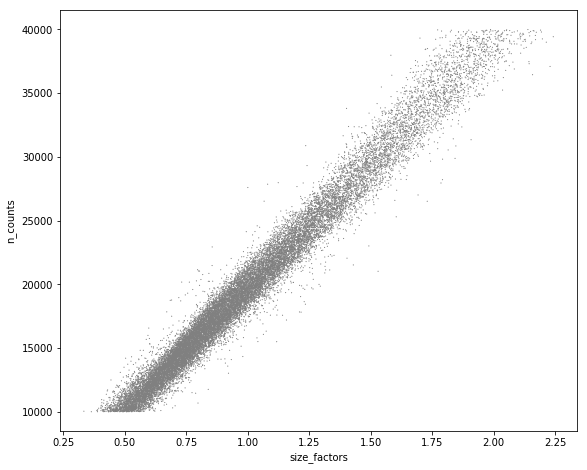

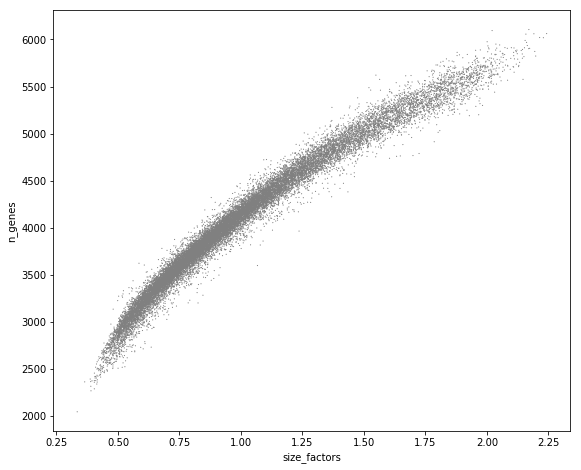

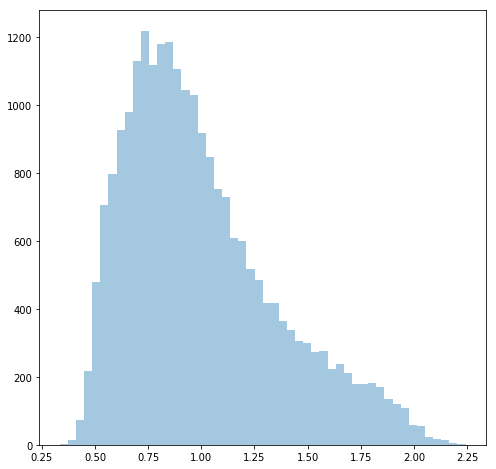

In [22]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [23]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [24]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [25]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [26]:
# ComBat batch correction
sc.pp.combat(adata, key='sample')

Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:269: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_it_sol" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'sum2', defined at /home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (311)

File "../../anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 311:
def _it_sol(s_data, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001) -> Tuple[float, float]:
    <source elided>
        g_new = (t2*n*g_hat + d_old*g_bar) / (t2*n + d_old)
        sum2 = s_data - g_new.reshape((g_new.shape[0], 1)) @ np.ones((1, s_data.shape[1]))
        ^

[1] During: typing of assignment at /home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (313)

File "../../anaconda3/envs/sc-tutorial/lib/

Adjusting data



MemoryError: 

# 2.4 Highly Variable Genes

In [ ]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

In [ ]:
sc.pl.highly_variable_genes(adata)

 ## 2.5 Visualization

In [ ]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.tsne(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

PCA:

Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
The plot does not show the expected clustering of the data in two dimensions
t-SNE:

Shows several distinct clusters with clear subcluster structure
Connections between clusters are difficult to interpret visually
UMAP:

Data points are spread out on the plot showing several clusters
Connections between clusters can be readily identified
Diffusion Maps:

Shows connections between regions of higher density
Very clear trajectories are suggested, but clusters are less clear
Each diffusion component extracts heterogeneity in a different part of the data
Graph:

Shows a central cluster and several outer clusters
Shows clear connections from the central cluster (likely stem cells) to outer clusters

## 2.6 Cell Cycle scoring

In [ ]:
#Score cell cycle and visualize the effect:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

In [ ]:
sc.pl.umap(adata, color=['S_score', 'G2M_score'], use_raw=False)
sc.pl.umap(adata, color='phase', use_raw=False)

## 3 Downstream Analysis

## 3.1 Clustering

In [ ]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

In [ ]:
adata.obs['louvain_r0.5'].value_counts()

In [ ]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['region', 'n_counts'])
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

## 3.2 Marker genes & cluster annotation

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['0','1','2'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['3','4','5'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['6', '7', '8'], fontsize=12)